In [1]:
import os
import sys
import hashlib

!pip install tensorflow_addons
!pip install rdkit
!pip install keras-swa

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import keras.backend as K
from tensorflow.keras import layers
from swa.tfkeras import SWA

from custom_loss import rwrmse, alpha_1point75, alpha_1point5, alpha_1point25, alpha_adaptive
from custom_loss import logistic_loss

import math as m
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem import AllChem
from rdkit.Chem import RDKFingerprint

from sklearn.preprocessing import StandardScaler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for keras-swa: filename=keras_swa-0.1.7-py3-none-any.whl size=7823 sha256=42aef52851d510742b2f6fa88ac68197a11d038eb394373361a7e61cd0d27297
  Stored in directory: /root/.cache/pip/wheels/1f/f3/68/48c5eb0509cd523f1c975e1240ae3d97540f6e2666bcdedae4
Successfully built keras-swa


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Set random seeds
np.random.seed(8)
tf.random.set_seed(8)

In [3]:
# Load training data
train_path = '/content/drive/MyDrive/Colab Notebooks/Input/singlecell/de_train.parquet'
df_train = pd.read_parquet(train_path)

In [4]:
# Get Morgan fingerprints
df_X = np.zeros([df_train.shape[0], 2048])
for i in range(df_train.shape[0]):
	df_X[i, :] = np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(df_train["SMILES"][i]), radius=2, nBits=2048))

In [5]:
# One hot encode the cells
# One hot ordering: [B cells,  Myeloid cells,  NK cells,  T cells CD4+,  T cells CD8+,  T regulatory cells]
one_hot = np.array(pd.get_dummies(df_train["cell_type"]) * 1.0)

In [6]:
# One hot encode controls
# 1 - control, 0 - otherwise
train_control = np.zeros([df_train.shape[0], 1])
for i, cont in enumerate(df_train["control"]):
  if cont == True:
    train_control[i] = 1.

In [7]:
# Get dose values
df_logfc = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Input/singlecell/logFC.parquet')
dose = np.array(df_logfc["dose_uM"])
dose = dose.reshape((df_train.shape[0], 1))

In [8]:
# Get cell count values for cell type, drug pairs
df_n_cell = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Input/singlecell/train_n_cells.csv')

In [9]:
# Get log p values for train set
df_chem = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Input/singlecell/chemical_properties.csv')
# Apply Log10 transform to n_atoms, molecular weight, and molar refractivity
df_chem["n_atoms"] = df_chem["n_atoms"].map(np.log10)
df_chem["mol_weight"] = df_chem["mol_weight"].map(np.log10)
df_chem["MR"] = df_chem["MR"].map(np.log10)

# Merge n cells onto df_chem
df_chem = df_chem.join(df_n_cell["n_cells"])

# Apply log10 transform to n_cells
df_chem["n_cells"] = df_chem["n_cells"].map(np.log10)

In [10]:
# Scale data
scaler = StandardScaler()
scaler.fit(df_chem[["log_P", "MR"]])

StandardScaler()

In [11]:
# Join to form training matrix
# Toggle to include dose and control
incl_control = True
if incl_control:
  one_hot = np.concatenate((one_hot, scaler.transform(df_chem[["log_P", "MR"]])), axis=1)
  one_hot = np.concatenate((one_hot, train_control), axis=1)
  x_train = np.concatenate((one_hot, df_X), axis=1)
else:
  # Normal features to be used
  one_hot = np.concatenate((one_hot, scaler.transform(df_chem[["log_P", "MR"]])), axis=1)
  x_train = np.concatenate((one_hot, df_X), axis=1)

In [12]:
x_train[:, 8]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [13]:
x_train.shape

(614, 2057)

In [14]:
# Make train data and targets
n_genes = 18211
y_train = np.array(df_train.iloc[:, 5:])

In [15]:
# Get sign matrix
output_sign = True
output_binary = False

# Compute sign matrix based on loss function used
if output_sign:
  y_sign = np.sign(y_train)

if output_binary:
  y_sign = np.sign(y_train)
  y_sign = (y_sign == 1) * 1. + (y_sign == -1) * 0.

In [16]:
np.min(y_train)

-180.5192016034818

In [17]:
np.max(y_train)

179.32417689610105

In [18]:
x_train.shape, y_train.shape, y_sign.shape

((614, 2057), (614, 18211), (614, 18211))

In [19]:
x_train.shape, y_train.shape, y_sign.shape

((614, 2057), (614, 18211), (614, 18211))

In [20]:
# Drop drugs which are not in the test set and which are not paired with B cells or myeloid cells
df_id = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Input/singlecell/id_map_submission.csv')

train_drugs = set(df_train["SMILES"])
test_drugs = set(df_id["SMILES"])
diff = train_drugs.difference(test_drugs)

# Get mask
cells = ['NK cells', 'T cells CD8+', 'T cells CD4+', 'T regulatory cells']
mask = (df_train["SMILES"].isin(diff) & df_train["cell_type"].isin(cells))

# Get index of False values
train_idx_list = list(mask[mask == False].index)

# Get new train
x_train = x_train[train_idx_list, :]
y_train = y_train[train_idx_list, :]
y_sign = y_sign[train_idx_list, :]

In [21]:
# Keep copy of x_train in original row order wrt df_train
x_train_copy = x_train
y_train_copy = y_train
y_sign_copy = y_sign

In [22]:
train_idx_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 100,
 101,
 102,
 103,
 104,
 105,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 2

In [23]:
len(train_idx_list)

548

In [24]:
x_train.shape, y_sign.shape

((548, 2057), (548, 18211))

In [25]:
# Model
# Architecture selection
skip_connections = False
selu_stack = True

# Create models
def create_skip_model():
  input_size = x_train.shape[1]
  inputs_reg = layers.Input((input_size,))
  x_1 = layers.Dense(3071, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(inputs_reg)
  x_2 = layers.Dense(3071, kernel_initializer="lecun_normal", bias_initializer="zeros")(x_1)
  concat_1 = layers.Concatenate(axis=1)([inputs_reg, x_2])
  selu_1 = layers.Activation(keras.activations.selu)(concat_1)
  x_3 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(selu_1)
  x_4 = layers.Dense(5128, kernel_initializer="lecun_normal", bias_initializer="zeros")(x_3)
  add_1 = layers.Add()([selu_1, x_4])
  selu_2 = layers.Activation(keras.activations.selu)(add_1)
  x_5 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(selu_2)
  x_6 = layers.Dense(5128, kernel_initializer="lecun_normal", bias_initializer="zeros")(x_5)
  add_2 = layers.Add()([selu_2, x_6])
  selu_3 = layers.Activation(keras.activations.selu)(add_2)
  x_7 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(selu_3)
  x_8 = layers.Dense(5128, kernel_initializer="lecun_normal", bias_initializer="zeros")(x_7)
  add_3 = layers.Add()([selu_3, x_8])
  selu_4 = layers.Activation(keras.activations.selu)(add_3)
  x_9 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(selu_4)
  if run_svd:
    output_reg = layers.Dense((q+1), kernel_initializer="glorot_normal")(x_9)
  if run_autoencoder:
    output_reg = layers.Dense(encoding_dim, kernel_initializer="glorot_normal")(x_9)
  model = keras.Model(inputs=inputs_reg, outputs=output_reg)
  return model

# Create SELU stack model
def create_selu_model():
  input_size = x_train.shape[1]
  inputs_sign = layers.Input((input_size,))
  x_1 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(inputs_sign)
  x_2 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(x_1)
  x_3 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(x_2)
  x_4 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(x_3)
  x_5 = layers.Dense(5128, activation="selu", kernel_initializer="lecun_normal", bias_initializer="zeros")(x_4)
  if output_sign:
    output = layers.Dense(n_genes, kernel_initializer="glorot_normal")(x_5)
  if output_binary:
    output = layers.Dense(n_genes, activation="sigmoid", kernel_initializer="glorot_normal")(x_5)
  model = keras.Model(inputs=inputs_sign, outputs=output)
  return model

In [26]:
# Skip connections model
if skip_connections:
  model = create_skip_model()

# SELU stack
if selu_stack:
  model = create_selu_model()

In [27]:
# Define losses
mae = keras.losses.MeanAbsoluteError()
mse = keras.losses.MeanSquaredError()
bce = keras.metrics.BinaryCrossentropy()

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2057)]            0         
                                                                 
 dense (Dense)               (None, 5128)              10553424  
                                                                 
 dense_1 (Dense)             (None, 5128)              26301512  
                                                                 
 dense_2 (Dense)             (None, 5128)              26301512  
                                                                 
 dense_3 (Dense)             (None, 5128)              26301512  
                                                                 
 dense_4 (Dense)             (None, 5128)              26301512  
                                                                 
 dense_5 (Dense)             (None, 18211)             934042

In [29]:
# Stochastic weight averaging
start_epoch = 2
swa = SWA(start_epoch=start_epoch,
          lr_schedule='manual',
          verbose=1)

# Optimizer
# Best scores used learning rate 7e-5, and SWA learning rate 5e-5
learning_rate = 7e-5

# Cosine rate scheduler
# Every 7800 steps, 200 epochs. Cosine Decay changes LR each batch (step)
# Every 3900 steps, 100 epochs
cos_sched = keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=learning_rate, first_decay_steps=1950, t_mul=1.0, m_mul=0.9, alpha=0.01)

# Optimisers
# Try higher weight decay for larger models
# lambda = lambda(norm) * sqrt(batch_size / (n * t)), where n is number of training points and t is number of epochs
# Try lambda(norm) between 0.025 to 0.05
weight_decay = 0.004 # Try 1e-2, 5e-2, 1e-1

opt = keras.optimizers.legacy.Adam(learning_rate=cos_sched)

opt_adamW = keras.optimizers.AdamW(learning_rate=cos_sched)

opt_adaMax = keras.optimizers.Adamax(learning_rate=cos_sched)

In [30]:
# Compile model for deriving JTT weights
model.compile(loss=logistic_loss, optimizer=opt_adamW, metrics=[logistic_loss])

# Train model # No SWA during initial train
model.fit(x=x_train, y=y_sign, epochs=50, batch_size=16, shuffle=True)

Epoch 1/50
35/35 [==============================] - 9s 85ms/step - loss: 0.6883 - logistic_loss: 0.6901
Epoch 2/50
35/35 [==============================] - 3s 83ms/step - loss: 0.6479 - logistic_loss: 0.6498
Epoch 3/50
35/35 [==============================] - 3s 83ms/step - loss: 0.6309 - logistic_loss: 0.6304
Epoch 4/50
35/35 [==============================] - 3s 83ms/step - loss: 0.6125 - logistic_loss: 0.6122
Epoch 5/50
35/35 [==============================] - 3s 84ms/step - loss: 0.5980 - logistic_loss: 0.5979
Epoch 6/50
35/35 [==============================] - 3s 86ms/step - loss: 0.5833 - logistic_loss: 0.5830
Epoch 7/50
35/35 [==============================] - 3s 86ms/step - loss: 0.5676 - logistic_loss: 0.5673
Epoch 8/50
35/35 [==============================] - 3s 83ms/step - loss: 0.5504 - logistic_loss: 0.5490
Epoch 9/50
35/35 [==============================] - 3s 83ms/step - loss: 0.5346 - logistic_loss: 0.5337
Epoch 10/50
35/35 [==============================] - 3s 83ms/ste

In [31]:
# Define row-wise accuracy (+1, -1)
def row_accuracy(y_true, y_pred):
  return (1/n_genes) * np.sum(y_true * y_pred, axis=1)

def row_accuracy_masked(y_true, y_pred, mask):
  return 1./np.sum(np.abs(mask), axis=1) * np.sum((y_true * mask) * (y_pred * mask), axis=1)

In [32]:
# Get sign prediction matrix (without row mask)

if output_sign:
  y_sign_pred = np.sign(model.predict(x_train_copy))

if output_binary:
  y_sign_pred = model.predict(x_train_copy)
  y_sign_pred = (y_sign_pred > 0.5) * 1.0 + (y_sign_pred <= 0.5) * - 1.0

18/18 [==============================] - 0s 8ms/step


In [33]:
y_sign_pred

array([[ 1., -1.,  1., ...,  1.,  1.,  1.],
       [ 1., -1.,  1., ...,  1.,  1., -1.],
       [-1., -1., -1., ...,  1.,  1., -1.],
       ...,
       [ 1., -1.,  1., ..., -1.,  1., -1.],
       [ 1., -1., -1., ..., -1.,  1., -1.],
       [-1., -1., -1., ..., -1.,  1., -1.]], dtype=float32)

In [34]:
# P-val mask
# Higher p-vals threshold means more values captured. P-val threshold means we want to get sign accuracy right on small p-values with large
# transformed values
# We want to focus on samples in rows, where log(p-val) is large and where getting sign correct is important
# Compute accuracy on these entries and select rows where accuracy is low
pv_thresh = 0.2
pv_mask = (np.abs(y_train_copy) >= -np.log10(pv_thresh)) * 1
pv_mask

array([[0, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 1, ..., 0, 0, 1]])

In [35]:
# Compute row-wise accuracy
err = row_accuracy(y_sign_copy, y_sign_pred)
err_pv = row_accuracy_masked(y_sign_copy, y_sign_pred, pv_mask)

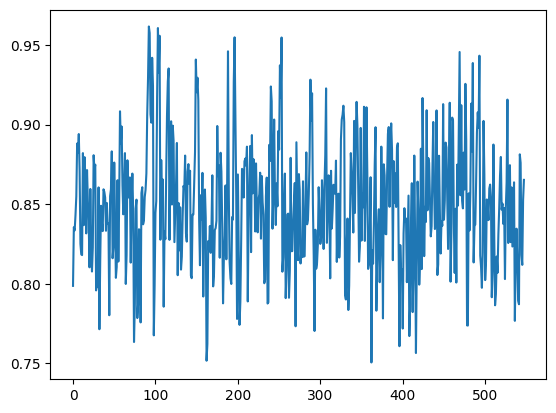

In [36]:
# Plot accuracy for all entries, all rows
plt.plot(err)
plt.show()

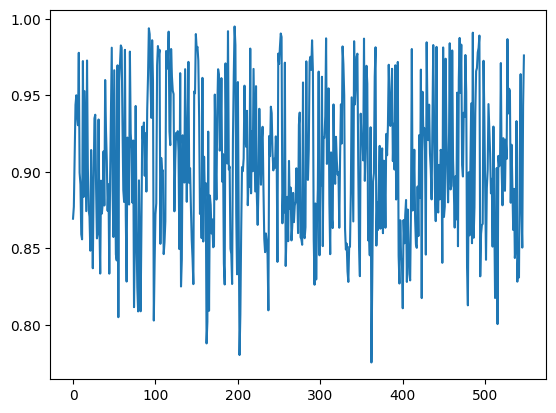

In [37]:
# Plot accuracy for all entries, all rows with p-vals below threshold
plt.plot(err_pv)
plt.show()

In [38]:
# Calculate stats for errors
err_med = np.median(err)
err_mean = np.mean(err)
err_std = np.sqrt(err_mean * (1 - err_mean) / 548)

err_med, err_mean, err_std

(0.8483334248531107, 0.8494539075003597, 0.015276166168150722)

In [ ]:
# Calculate stats for errors with p-val cutoff
err_med_pv = np.median(err_pv)
err_mean_pv = np.mean(err_pv)
err_std_pv = np.sqrt(err_mean_pv * (1 - err_mean_pv) / 548)

err_med_pv, err_mean_pv, err_std_pv

(0.8644678286247746, 0.8691049327445829, 0.01361173740389046)

In [44]:
# Get indices of samples with accuracy below cutoff
cutoff = err_mean - 1.96 * err_std # using 75% and below accuracy cutoff, can also use err_mean - err_std
idx_list = np.where((err <= cutoff) & (x_train[:, 8] == 0))[0]

In [ ]:
# Get indices of samples with accuracy below cutoff (p-vals)
cutoff = err_mean_pv - 3 * err_std_pv
idx_list = np.where((err_pv <= cutoff) & (x_train[:, 8] == 0))[0]

In [48]:
len(idx_list)

130

In [49]:
idx_list

array([  0,  10,  11,  20,  23,  28,  29,  30,  32,  33,  44,  48,  52,
        53,  55,  64,  65,  70,  74,  75,  78,  79,  82,  98,  99, 110,
       127, 131, 132, 143, 144, 154, 158, 162, 163, 167, 170, 171, 178,
       182, 183, 186, 190, 191, 192, 199, 202, 203, 212, 232, 233, 236,
       237, 254, 255, 258, 259, 262, 263, 270, 273, 276, 278, 280, 281,
       292, 293, 295, 296, 312, 320, 323, 330, 331, 334, 335, 347, 358,
       359, 362, 364, 368, 369, 372, 376, 388, 396, 398, 399, 400, 405,
       408, 409, 412, 413, 416, 417, 420, 421, 423, 426, 442, 443, 446,
       458, 463, 465, 478, 479, 486, 494, 495, 496, 497, 500, 501, 508,
       509, 512, 513, 514, 515, 524, 536, 537, 539, 540, 541, 544, 545])

In [ ]:
# Idx list 0.75 accuracy cutoff on all samples
idx_list = [  8,   9,  10,  11,  12,  30,  31,  32,  33,  34,  38,  40,  56,
        72,  73,  74,  75,  76,  86,  87,  90,  91,  94,  95,  96,  97,
       118, 130, 151, 154, 155, 156, 157, 158, 168, 169, 170, 171, 174,
       193, 194, 201, 202, 223, 229, 230, 233, 234, 235, 236, 267, 268,
       271, 272, 297, 309, 313, 315, 316, 317, 327, 336, 377, 381, 382,
       405, 409, 410, 411, 412, 413, 414, 419, 447, 448, 451, 452, 456,
       459, 460, 467, 475, 477, 478, 517, 518, 519, 520, 521, 523, 540,
       541, 556, 557, 558, 559, 579, 602, 603, 607]

In [ ]:
# Idx list for mean - 3 x std cutoff on accuracy for all samples with p-vals <= 0.2
idx_list = [  8,   9,  10,  11,  12,  14,  23,  25,  28,  29,  34,  38,  41,
        44,  52,  56,  60,  63,  72,  73,  74,  75,  76,  77,  84,  86,
        87,  89,  90,  91,  93,  94,  95,  96,  97,  99, 118, 119, 120,
       121, 126, 127, 130, 131, 154, 155, 156, 157, 158, 168, 169, 174,
       175, 177, 187, 193, 194, 196, 198, 201, 202, 214, 215, 222, 223,
       224, 229, 230, 232, 233, 234, 235, 236, 239, 240, 267, 268, 271,
       272, 287, 295, 297, 300, 303, 305, 306, 307, 310, 315, 316, 317,
       320, 321, 323, 324, 335, 336, 338, 342, 355, 356, 357, 358, 365,
       377, 379, 380, 381, 382, 393, 395, 405, 407, 409, 410, 411, 412,
       413, 414, 419, 424, 444, 447, 448, 449, 450, 451, 452, 453, 455,
       456, 459, 460, 464, 467, 468, 470, 474, 477, 483, 503, 517, 518,
       519, 520, 521, 522, 523, 540, 541, 543, 546, 548, 556, 557, 563,
       567, 578, 579, 581, 587, 602, 603, 605, 606, 607, 608, 611]

In [50]:
# Idx list for mean - 2 x std cutoff with drugs not in test thrown out
# Note that train, target needs to have same rows thrown out to be consistent for upsampling
idx_list = [  0,  10,  11,  20,  23,  28,  29,  30,  32,  33,  44,  48,  52,
        53,  55,  64,  65,  70,  74,  75,  78,  79,  82,  98,  99, 110,
       127, 131, 132, 143, 144, 154, 158, 162, 163, 167, 170, 171, 178,
       182, 183, 186, 190, 191, 192, 199, 202, 203, 212, 232, 233, 236,
       237, 254, 255, 258, 259, 262, 263, 270, 273, 276, 278, 280, 281,
       292, 293, 295, 296, 312, 320, 323, 330, 331, 334, 335, 347, 358,
       359, 362, 364, 368, 369, 372, 376, 388, 396, 398, 399, 400, 405,
       408, 409, 412, 413, 416, 417, 420, 421, 423, 426, 442, 443, 446,
       458, 463, 465, 478, 479, 486, 494, 495, 496, 497, 500, 501, 508,
       509, 512, 513, 514, 515, 524, 536, 537, 539, 540, 541, 544, 545]

In [51]:
x_train[idx_list, 0:6]

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0.